In [1]:
import pandas as pd
import difflib as dl

# Assembly and cleaning
First we assemble all the data, and in some cases we have to reformat some of the sequences. when all is done we clean the data by making everything lowercase

In [2]:
def coin_name_fix(df):
    df['coin'] = df['coin'].str.replace("0.5EUR", "0.50EUR").replace("0.2EUR", "0.20EUR").replace("0.1EUR", "0.10EUR").replace('0.05NZD', '0.50NZD')
    df['coin'] = df['coin'].str.replace('10ct', '0.10EUR').replace('20ct', '0.20EUR').replace('50ct', '0.50EUR').replace('5ct euro', '0.05EUR')
    df['coin'] = df['coin'].str.replace("1 euro", "1EUR").replace('1eu','1EUR')

    return df

In [3]:
def cleaning(df,file):
    if file == 'František': # František has a different format
        df["sequence"] = df['sequence'].str.replace("x", "t")
        df['sequence'] = df['sequence'].str.replace("o", "h")
        df['sequence'] = df['sequence'].str.replace("f", "x")
    if file == 'Kaleem': # Kaleem has a different format
        df['sequence'] = df['sequence'].str.replace("y", "x")
    df['sequence'] = df['sequence'].str.lower()
    return df

In [4]:
files = ['Amir','DavidV',"František",'Kaleem','Pierre', 'DavidKL']
df = pd.DataFrame()
for file in files:
    f = pd.read_csv(f'Audit_data/{file}.csv', header = 0)
    f = cleaning(f,file)
    f['auditor'] = file
    df = pd.concat([df,f], axis = 0, ignore_index = True)


In [5]:
david_autocorrelated  = pd.read_excel('Data coins David Voss.xlsx', header=0)
david_autocorrelated = cleaning(david_autocorrelated, 'David Voss')
david_autocorrelated = coin_name_fix(david_autocorrelated)

C:\Users\amisa\AppData\Local\Temp\ipykernel_2868\3142134136.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['coin'] = df['coin'].str.replace("0.5EUR", "0.50EUR").replace("0.2EUR", "0.20EUR").replace("0.1EUR", "0.10EUR").replace('0.05NZD', '0.50NZD')


# Getting reported data
Now we need to get the original data form the tosser's to compare

In [6]:
bachelor_f = pd.read_csv('bachelor_data.csv', header = 0)
marathon_f = pd.read_csv('marathon_data.csv', header = 0)
bachelor = coin_name_fix(pd.DataFrame(bachelor_f))
marathon = coin_name_fix(pd.DataFrame(marathon_f))
reported = []
start = []
for _,i in df.iterrows():
    if i['person'] == 'kaleemU' and i['sequence_id'] == 25:
        reported.append(bachelor.loc[((bachelor['sequence_id'] == i['sequence_id']) & (bachelor['person'] == 'irmaT'))]['sequence'].values[0])
        start.append(bachelor.loc[((bachelor['sequence_id'] == i['sequence_id']) & (bachelor['person'] == 'irmaT'))]['start'].values[0])
    elif i['group'] == 'bachelor':
        reported.append(bachelor.loc[((bachelor['sequence_id'] == i['sequence_id']) & (bachelor['person'] == i['person']))]['sequence'].values[0])
        start.append(bachelor.loc[((bachelor['sequence_id'] == i['sequence_id']) & (bachelor['person'] == i['person']))]['start'].values[0])
    else:
        reported.append(marathon.loc[((marathon['sequence_id'] == i['sequence_id']) & (marathon['person'] == i['person']))]['sequence'].values[0])
        start.append(marathon.loc[((marathon['sequence_id'] == i['sequence_id']) & (marathon['person'] == i['person']))]['start'].values[0])
df['reported_sequence'] = reported
df['start'] = start


C:\Users\amisa\AppData\Local\Temp\ipykernel_2868\3142134136.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['coin'] = df['coin'].str.replace("0.5EUR", "0.50EUR").replace("0.2EUR", "0.20EUR").replace("0.1EUR", "0.10EUR").replace('0.05NZD', '0.50NZD')


In [7]:
auto_corr_bachelor = pd.concat([bachelor.loc[bachelor['person'] != 'davidV'], david_autocorrelated], axis = 0, ignore_index = True)
merged = pd.concat([bachelor,marathon], axis = 0, ignore_index = True)
merged_auto_corr = pd.concat([auto_corr_bachelor,marathon], axis = 0, ignore_index = True)

In [9]:
from Levenshtein import distance

def switch(audit):
    audit = audit.replace("h", "V")
    audit = audit.replace("t", "h")
    audit = audit.replace("V", "t")
    return audit

def switcher(audit, report):
    current_distance = distance(audit, report)
    audit_new = switch(audit)
    if distance(audit_new, report) < current_distance:
        return audit_new
    else:
        return audit

In [10]:
corrected_sequence = []
for _,i in df.iterrows():
    Best_match = switcher(i['sequence'],i['reported_sequence'])
    corrected_sequence.append(Best_match)    
df['corrected_sequence'] = corrected_sequence


In [11]:
df['cleaned_sequence'] = df['corrected_sequence'].str.replace("x", "")
df['cleaned_sequence'] = df['cleaned_sequence'].str.replace("u", "")
df['cleaned_sequence'] = df['cleaned_sequence'].str.replace(" ", "")
df['cleaned_reported_sequence'] = df['reported_sequence'].str.replace("x", "")
df['cleaned_reported_sequence'] = df['cleaned_reported_sequence'].str.replace(" ", "")

# Comparing
Now that we have both reported and audited sequences we can start comparing them

In [12]:
correct = []
for _,i in df.iterrows():
    if i['cleaned_sequence'] == i['cleaned_reported_sequence']:
        correct.append(1)
    else:
        correct.append(0)
df['correct'] = correct

Using this we can see that 13 trails are completely correct, even without considering possible 1-off errors

# Naive approach
Using a naive approach we can see that Pierre's data is extremely accurate with only 2 mistakes. everything else is still unclear, presumably because of misalignment 

In [13]:
def naive_check(audit,reported):
    errors = []
    succes = []
    for i in range(min(len(audit),len(reported))):
        if audit[i] == reported[i] or audit[i] == "_" or reported[i] == "_":
            errors.append(0)
        else:
            errors.append(1)
    return errors

In [14]:
sequences_errors = []
for _,i in df.iterrows():
    sequences_errors.append(sum(naive_check(i['cleaned_sequence'],i['cleaned_reported_sequence'])))	
df['sequence_errors'] = sequences_errors



In [15]:
def succes_decoder(sequence, start):
    succes = []
    for index,letter in enumerate(sequence):
        if index == 0:
            if letter == start or letter == '_':
                succes.append(1)
            else:
                succes.append(0)
        else:
            if letter == last or letter == '_':
                succes.append(1)
            else:
                succes.append(0)
        last = letter
    return succes

In [17]:
bachelor['head_count'] = bachelor['sequence'].str.count("h")
bachelor['tail_count'] = bachelor['sequence'].str.count("t")
marathon['head_count'] = marathon['sequence'].str.count("h")
marathon['tail_count'] = marathon['sequence'].str.count("t")
print(f'bachelor head: {bachelor["head_count"].sum()} tail: {bachelor["tail_count"].sum()} marathon head: {marathon["head_count"].sum()} tail: {marathon["tail_count"].sum()}')
print(f'total head: {bachelor["head_count"].sum() + marathon["head_count"].sum()} total tail: {bachelor["tail_count"].sum() + marathon["tail_count"].sum()}')
29323+29874

bachelor head: 37562 tail: 37474 marathon head: 29323 tail: 29874
total head: 66885 total tail: 67348


59197

In [18]:
print(auto_corr_bachelor.value_counts('start'))
print(marathon.value_counts('start'))


start
t    381
h    360
dtype: int64
start
h    300
t    292
x      1
dtype: int64


In [16]:
import numpy as np
 
def get_minimum_penalty(x:str, y:str, pxy:int, pgap:int):
    """
    Function to find out the minimum penalty
 
    :param x: pattern X
    :param y: pattern Y
    :param pxy: penalty of mis-matching the characters of X and Y
    :param pgap: penalty of a gap between pattern elements
    """
 
    # initializing variables
    i = 0
    j = 0
     
    # pattern lengths
    m = len(x)
    n = len(y)
     
    # table for storing optimal substructure answers
    dp = np.zeros([m+1,n+1], dtype=int) #int dp[m+1][n+1] = {0};
 
    # initialising the table
    dp[0:(m+1),0] = [ i * pgap for i in range(m+1)]
    dp[0,0:(n+1)] = [ i * pgap for i in range(n+1)]
 
    # calculating the minimum penalty
    i = 1
    while i <= m:
        j = 1
        while j <= n:
            if x[i - 1] == y[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = min(dp[i - 1][j - 1] + pxy,
                                dp[i - 1][j] + pgap,
                                dp[i][j - 1] + pgap)
            j += 1
        i += 1
     
    # Reconstructing the solution
    l = n + m   # maximum possible length
    i = m
    j = n
     
    xpos = l
    ypos = l
 
    # Final answers for the respective strings
    xans = np.zeros(l+1, dtype=int)
    yans = np.zeros(l+1, dtype=int)
     
 
    while not (i == 0 or j == 0):
        #print(f"i: {i}, j: {j}")
        if x[i - 1] == y[j - 1]:       
            xans[xpos] = ord(x[i - 1])
            yans[ypos] = ord(y[j - 1])
            xpos -= 1
            ypos -= 1
            i -= 1
            j -= 1
        elif (dp[i - 1][j - 1] + pxy) == dp[i][j]:
         
            xans[xpos] = ord(x[i - 1])
            yans[ypos] = ord(y[j - 1])
            xpos -= 1
            ypos -= 1
            i -= 1
            j -= 1
         
        elif (dp[i - 1][j] + pgap) == dp[i][j]:
            xans[xpos] = ord(x[i - 1])
            yans[ypos] = ord('_')
            xpos -= 1
            ypos -= 1
            i -= 1
         
        elif (dp[i][j - 1] + pgap) == dp[i][j]:       
            xans[xpos] = ord('_')
            yans[ypos] = ord(y[j - 1])
            xpos -= 1
            ypos -= 1
            j -= 1
         
 
    while xpos > 0:
        if i > 0:
            i -= 1
            xans[xpos] = ord(x[i])
            xpos -= 1
        else:
            xans[xpos] = ord('_')
            xpos -= 1
     
    while ypos > 0:
        if j > 0:
            j -= 1
            yans[ypos] = ord(y[j])
            ypos -= 1
        else:
            yans[ypos] = ord('_')
            ypos -= 1
 
    # Since we have assumed the answer to be n+m long,
    # we need to remove the extra gaps in the starting
    # id represents the index from which the arrays
    # xans, yans are useful
    id = 1
    i = l
    while i >= 1:
        if (chr(yans[i]) == '_') and chr(xans[i]) == '_':
            id = i + 1
            break
         
        i -= 1
 
    # Printing the final answer
    # print(f"Minimum Penalty in aligning the genes = {dp[m][n]}")
    # print("The aligned genes are:")   
    # X
    i = id
    x_seq = ""
    while i <= l:
        x_seq += chr(xans[i])
        i += 1
 
    # Y
    i = id
    y_seq = ""
    while i <= l:
        y_seq += chr(yans[i])
        i += 1
    return [x_seq, y_seq]

 

In [17]:

markings = []
errors = []
succes = []
sum_errors = []
for _,i in df.iterrows():
    x = get_minimum_penalty(i['cleaned_sequence'],i['cleaned_reported_sequence'],1,3)
    error_trail = naive_check(x[0],x[1])
    errors.append(error_trail)
    succes.append(succes_decoder(x[0], i['start']))
    sum_errors.append(sum(errors[-1]))
    if sum(errors[-1]) >= 10:
        print(i['person'])
        print(sum(error_trail))
        print(x[0])
        print(x[1])
        markings.append("x")
    else:
        markings.append("") 
df['marked'] = markings
df['errors'] = errors
df['succes'] = succes
df['sum_errors'] = sum_errors


kaleemU
13
hhtthhhhthhhttthhththhhthttttttthhtttttthtthhtthhththhhhtthhtththhthhttttthtttthhhhthththhtttt_tthhttthhth
hh_thhhhthhh_tthhththhhthhttttttthhtttttththttthhtht__hhtthhtththh_hh_tttthtttthhhhththhhhtttthhttthhthhtt
alexandraS
35
hhhthtttthtttthhthhthhhhttththtthtthhthtthththhhhhhthttttthtthhthhthhhhhhhhtthhhhthhtthhhttttthhhttttttht
_hhththhththtt_hthhhhthhthhtthhhhthhhth_thttthhhtthhtthttthhtttthhthhhttthhtt_thh_hhthhtttthhtthhhhhththh
madlenH
11
thhttttttthtthhthtthhhttthhhhhhhhthhhhtthhhhhhttthhhhthhhthhhhhhtttthhhtthhththtthhhthttthhtthhtthhhhhtttthtthh
t_tthhttttttthtththtthhtt_thhhhhhthhhhtt_hhhhhttthhhhthhhthhhhhh_ttthhhtthhttthtthhhthttthhtthh_thhhhh___t_tt__
ingeborgR
40
thhtthhhtthhhhhhththtthtttthth_htthhtttthhhththttttthtthttthhttthhtttttthhtththtthththtththhhhhtthht
hthtttthtthhhttthhhhtthtttttththhhhhhhttttthhththhhttttttttthttthththtthhhhtttthtthhthtttttthtttttht
adamF
35
thhthtttththhhhthhhtthhhtththhhhhttththtthhhhhhthhtthhhthhth_hthhhhtttttthth_hthtththhtth_

In [18]:
# sum(df['errors'].apply(lambda x: sum(x)))
sum(df.loc[df['marked'] != 'x']['errors'].apply(lambda x: sum(x)))

57

In [117]:
df['person_factor'] = pd.factorize(df['person'])[0] + 1
df= df.loc[df['marked'] != 'x']
exploded_df = df.explode(['errors', 'succes'])[['person', 'person_factor', 'errors', 'succes']]
exploded_df['errors'] = exploded_df['errors'].astype(int)
exploded_df.to_csv('auditdata_fixed.csv', index=False)

In [25]:
# len(exploded_df.loc[(exploded_df['errors'] == 1 ) & (exploded_df['succes'] == 1)])
# len(exploded_df.loc[(exploded_df['errors'] == 1 ) & (exploded_df['succes'] == 0)])
print(merged.explode('succes'))
print(exploded_df['succes'].mean())

KeyError: 'succes'

In [146]:
succes = []
merged = merged.loc[merged['sequence'] != "x"] # Some of the 1 letter sequences are not valid
for _,i in merged.iterrows():
    succes.append(succes_decoder(i['sequence'].replace("x",""), i['start']))
merged['succes'] = succes


In [23]:
succes = []
merged_auto_corr = merged_auto_corr.loc[merged_auto_corr['sequence'] != "x"] # Some of the 1 letter sequences are not valid
for _,i in merged_auto_corr.iterrows():
    succes.append(succes_decoder(i['sequence'].replace("x",""), i['start']))
merged_auto_corr['succes'] = succes

In [39]:
import matplotlib.pyplot as plt
from scipy import stats
from numpy import mean

In [ ]:
def count(x):
    count = 0
    for i in x:
        if i == "t":
            count += 1
    return count
def proportion(df):
    prop = df['counts']
    return 
def plotting(persons,df, rows, columns):
    plt.figure(figsize=(20,10))
    for j,i in enumerate(persons, start = 1):
        current_df = df.loc[df["person"] == i]
        plot_counts = current_df["counts"].loc[df["counts"] > 0]
        theoretical =[stats.binom.pmf(k = x,n = 100, p = current_df['counts'].mean()/100) for x in range(0,len(current_df['counts']))]
        theoretical = [int(x*150) for x in theoretical]
        plt.subplot(rows,columns,j)
        plt.bar(range(0,len(current_df['counts'])),theoretical, color="red", alpha=0.3, label = "Theoritical")
        plt.hist(plot_counts, bins = 100, color="blue", alpha=1, label = "Experimental")
        plt.legend()
        plt.title(i)
        plt.xlim([0,100])
        plt.ylim([0,20])
        # plt.xlabel("Number of Heads")
    plt.show()

def main(df, rows, columns):
    df["counts"] = [count(x) if len(x) > 1 else None for x in df["sequence"]]
    plotting(df["person"].unique(),df, rows, columns)



In [ ]:
main(bachelor,3,2)

In [ ]:
main(marathon, 3,3)

In [118]:
merged = pd.concat([marathon, bachelor], ignore_index=True)
merged['factor_person'] = pd.factorize(merged['person'])[0] + 1
merged['factor_coin'] = pd.factorize(merged['coin'])[0] + 1
merged.explode('succes')[['person','factor_person', 'coin', 'factor_coin', 'succes']].to_csv('merged.csv', index=False)


In [130]:
merged.explode('succes')['succes'].mean()

NameError: name 'merged' is not defined

<AxesSubplot:title={'center':'Coin distribution'}, xlabel='Coins', ylabel='Counts'>

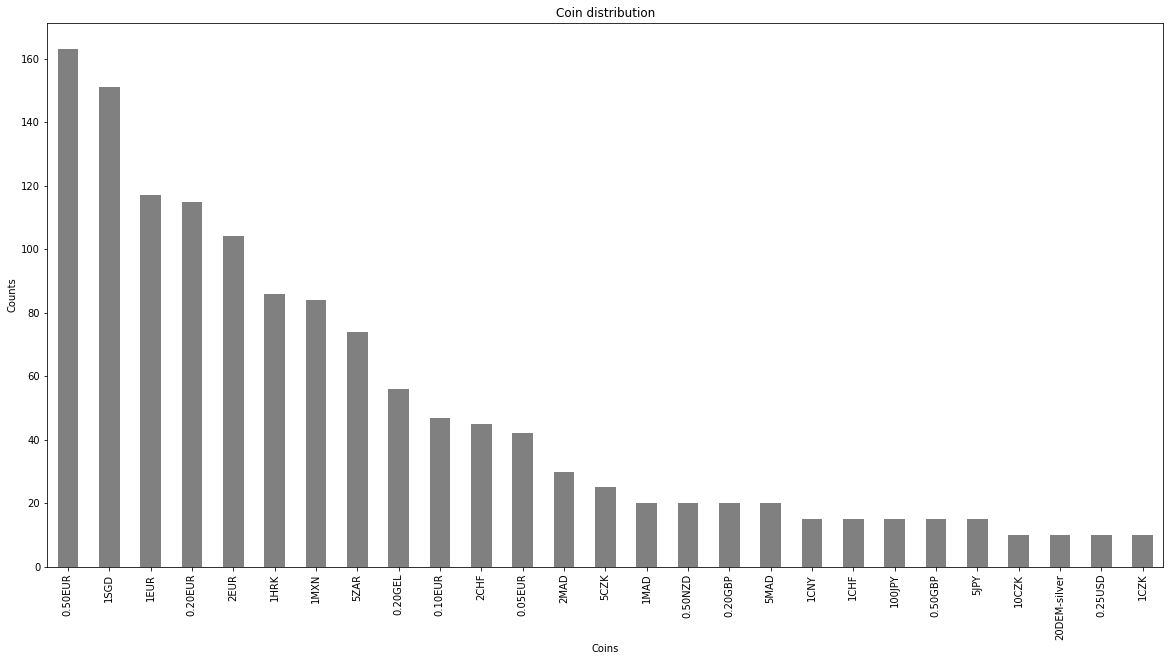

In [97]:
# merged['succes_sum'] = merged['succes'].apply(lambda x: sum(x))
# pd.pivot_table(merged, values='succes_sum', index=['sequence_id'], columns=['person']).plot(figsize= (20,10))
merged.value_counts('coin').plot(kind='bar', figsize= (20,10), color = 'gray', title= "Coin distribution", xlabel= "Coins", ylabel= "Counts")


In [43]:
exploed = merged.explode('succes')
# exploed.loc[exploed['succes'] != 1].sort_values('succes')

In [62]:
f = pd.read_csv('merged.csv')
df = pd.DataFrame(f)
# print(df.groupby("factor_coin").mean()['succes'])
# print(df.groupby("factor_person").mean()['succes'])
df.groupby('coin')["succes"].agg([np.mean,np.std, len]).sort_index()

,mean,std,len
coin,,,
0.05EUR,0.514123,0.499860,4213
0.05NZD,0.513675,0.499937,2011
0.10EUR,0.509584,0.499957,5165
0.20EUR,0.500334,0.500021,11968
0.20GBP,0.478803,0.499675,2005
0.20GEL,0.510182,0.499941,5598
0.25USD,0.491000,0.500169,1000
0.50GBP,0.490691,0.500080,1504
0.5EUR,0.505829,0.499981,16298


In [104]:
n = 100
p = 0.6
# defining list of r values
[stats.binom.pmf(r, n, p)*150 for r in range(0,100)]

[2.410407066388499e-38,
 3.61561059958273e-36,
 2.6845908701901867e-34,
 1.3154495263931958e-32,
 4.784947652255239e-31,
 1.3780649238495104e-29,
 3.272904194142592e-28,
 6.592564162487176e-27,
 1.1495783758337124e-25,
 1.7626868429450217e-24,
 2.4060675406199534e-23,
 2.952901072579041e-22,
 3.2851024432441527e-21,
 3.33564248083253e-20,
 3.109295312490343e-19,
 2.6739939687416906e-18,
 2.130838943841036e-17,
 1.5793276877880533e-16,
 1.0923683173867408e-15,
 7.071647528345755e-15,
 4.2960258734700383e-14,
 2.454871927697148e-13,
 1.3222832883277767e-12,
 6.726397597145703e-12,
 3.2370788436263666e-11,
 1.476107952693629e-10,
 6.387005564539708e-10,
 2.6257689543107635e-09,
 1.0268632160608246e-08,
 3.824180252916165e-08,
 1.3575839897852447e-07,
 4.5982683524983614e-07,
 1.4872524202611995e-06,
 4.59696202626186e-06,
 1.3588078930568144e-05,
 3.843485183217871e-05,
 0.00010409439037881725,
 0.0002700827426044992,
 0.0006716531362138192,
 0.0016016344017406473,
 0.0036637386939817234,